In [1]:
using LinearAlgebra
using Unitful
using UnitfulAstro
using OrdinaryDiffEq
using Plots
using CoordinateTransformations
#using FLoops
#using Distributed
#using DisplayAs
#include("./GalaxyCollisionFunctions.jl")
#addprocs(4)
theme(:dracula)
using Random

In [20]:
const G = 4.3009E-3 *1u"pc *(km/s)^2 /Msun"

function Spherical2Polar(r,ϕ,θ)
    x = r * cos(ϕ)* sin(θ)
    y = r*sin(ϕ)*sin(θ)
    z = r*cos(θ)
return [x,y,z]
end
function format_parameters(galaxy_args)
    #I didn't have this at first, but this makes all galaxies have an uniform format. Not too crazy
    return Dict(
        "mass" => galaxy_args[1]*1u"Msun",
        "DiskRadius"     => galaxy_args[2]*1u"kpc",
        "BulgeRadius" => galaxy_args[3]*1u"kpc",
        "center_pos" => galaxy_args[4].*1u"kpc",
        "center_vel" => galaxy_args[5].*1u"km/s",
        "normal"     => galaxy_args[6],
        "NₛDisk"    => galaxy_args[7],
        "NₛBulge"    => galaxy_args[8],
        "softening"  => galaxy_args[9]
    )
end
function init_disk!(galaxy,dT=1E-4u"Myr")
    #=
    This function takes a 'galaxy' as an argument, which is an array of 8 arguments=>
        [mass,DiskRadius,center_pos,center_vel,normal,N_rings,N_stars,softening]
    And outputs the star positions, velocities and the velocity scale.
    =#
#-------------------------------------------------------------Rotations--------------------------------------------------------------
    if norm(galaxy["normal"]) == 0 
        Rotation = I
    else 
        cosθ = normalize(galaxy["normal"])[3]
        sinθ = √(1-cosθ^2)
        u = [0,0,1] × normalize(galaxy["normal"])
        if norm(u) == 0 
            Rotation = I
        else 
         u = normalize(u)

        Rotation = [
            u[1]*u[1]*(1-cosθ)+cosθ u[1]*u[2]*(1-cosθ)-u[2]*sinθ u[1]*u[3]*(1-cosθ)+u[1]*sinθ;

            u[2]*u[1]*(1-cosθ)+u[3]*sinθ u[2]*u[2]*(1-cosθ)+cosθ u[2]*u[3]*(1-cosθ)-u[1]*sinθ;

            u[3]*u[1]*(1-cosθ)+u[2]*sinθ u[3]*u[1]*(1-cosθ)+u[1]*sinθ u[3]*u[3]*(1-cosθ)+cosθ
            ]
        end
    end
#-----------------------------------------------------------------------------------------------------------------------------------
    galaxy["star_pos"] = []
    galaxy["star_vel"] = []
#----------------------------------------------------------------------Making the Disk--------------------------------------------------------------------------------------------
    Rminimum = galaxy["softening"] * galaxy["DiskRadius"]
    Rdisk = (-log.(rand(galaxy["NₛDisk"]))*galaxy["DiskRadius"] .+Rminimum)*1u"1/kpc" #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
    ϕdisk = 2π *rand(galaxy["NₛDisk"])
    # Positions 
    vecᵣ = (Rotation * ([Rdisk.*cos.(ϕdisk),Rdisk.*sin.(ϕdisk),zeros(galaxy["NₛDisk"])]))
    x = ustrip.(u"m",galaxy["center_pos"][1].+vecᵣ[1]*1u"kpc")#here, we strip our units into our 'integrating' unitlessness because units don't really play nice in arrays of arrays
    y = ustrip.(u"m",galaxy["center_pos"][2].+vecᵣ[2]*1u"kpc")
    z = ustrip.(u"m",galaxy["center_pos"][3].+vecᵣ[3]*1u"kpc")

    # Velocities
    BlackMagic = 
    vecᵥ = []
    for j ∈ 1:galaxy["NₛDisk"]
        push!(vecᵥ,ustrip.(u"m/s",√(G *galaxy["mass"]/(Rdisk[j]*1u"kpc"))) * normalize(reduce(vcat,transpose(vecᵣ))[:,j] × galaxy["normal"])*(2*(rand()>0.5)-1))
    end
   #=  Tₛ = 2π * uconvert.(u"s",sqrt.((Rdisk*1u"kpc").^3/(G *galaxy["mass"])))
    Δϕ = 2π *uconvert(u"s",dT)./Tₛ 
    vecᵥ = (Rotation* [(Rdisk/(uconvert(u"s",dT)*1u"1/s")).*(cos.(ϕdisk)-cos.(ϕdisk-Δϕ)),Rdisk/(uconvert(u"s",dT)*1u"1/s").*(sin.(ϕdisk)-sin.(ϕdisk-Δϕ)),zeros(galaxy["NₛDisk"])])*1u"kpc/s" =#
    v₁ = ustrip.(u"m/s",galaxy["center_vel"][1]).+reduce(vcat,transpose(vecᵥ))[:,1]
    v₂ = ustrip.(u"m/s",galaxy["center_vel"][2]).+reduce(vcat,transpose(vecᵥ))[:,2]
    v₃ = ustrip.(u"m/s",galaxy["center_vel"][3]).+reduce(vcat,transpose(vecᵥ))[:,3]
    #= v₁ = ustrip.(u"m/s",galaxy["center_vel"][1].+vecᵥ[1])
    v₂ = ustrip.(u"m/s",galaxy["center_vel"][2].+vecᵥ[2])
    v₃ =ustrip.(u"m/s",galaxy["center_vel"][3].+vecᵥ[3]) =#
    for j ∈ 1:galaxy["NₛDisk"]
        push!(galaxy["star_pos"],[x[j],y[j],z[j]])
        push!(galaxy["star_vel"],[v₁[j],v₂[j],v₃[j]])
    end
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------Making Bulge-----------------------------------------------------------------------------------------
    Rminimum = galaxy["softening"] * galaxy["BulgeRadius"]
    Rbulge = (-log.(rand(galaxy["NₛBulge"]))*galaxy["BulgeRadius"] .+Rminimum) #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
    ϕbulge = 2π *rand(galaxy["NₛBulge"])
    θbulge = π *rand(galaxy["NₛBulge"])
    vecᵣbulge = Spherical2Polar.(ustrip.(u"m",Rbulge),ϕbulge,θbulge)
    Xbulge = ustrip(u"m",galaxy["center_pos"][1]).+reduce(vcat,transpose(vecᵣbulge))[:,1]
    Ybulge = ustrip(u"m",galaxy["center_pos"][2]).+reduce(vcat,transpose(vecᵣbulge))[:,2]
    Zbulge = ustrip(u"m",galaxy["center_pos"][3]).+reduce(vcat,transpose(vecᵣbulge))[:,3]
    Vbulge = []
    for j ∈ 1:galaxy["NₛBulge"]
        push!(Vbulge,ustrip.(u"m/s",√(G *galaxy["mass"]/Rbulge[j])) *normalize(vecᵣbulge[j] × rand(3)))
    end
    v₁bulge = ustrip(u"m/s",galaxy["center_vel"][1]).+reduce(vcat,transpose(Vbulge))[:,1]
    v₂bulge = ustrip(u"m/s",galaxy["center_vel"][2]).+reduce(vcat,transpose(Vbulge))[:,2]
    v₃bulge = ustrip(u"m/s",galaxy["center_vel"][3]).+reduce(vcat,transpose(Vbulge))[:,3]
    for j ∈ 1:galaxy["NₛBulge"]
        push!(galaxy["star_pos"],[Xbulge[j],Ybulge[j],Zbulge[j]])
        push!(galaxy["star_vel"],[v₁bulge[j],v₂bulge[j],v₃bulge[j]])
    end
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
end

function evolve_disk(galaxy,dT=1e-4u"yr",N_steps=100000,frames=500)
    divs = trunc(Int64,N_steps/frames)
    #Integration stuff
    dT=ustrip(u"s",dT)
    rₘ=ustrip(u"m",galaxy["softening"]*galaxy["BulgeRadius"])
    Nₛ=galaxy["NₛDisk"]+galaxy["NₛBulge"]
    
    #Galaxy stuff
    M = galaxy["mass"]
    X,Y,Z = ustrip.(u"m",galaxy["center_pos"])
    Vx,Vy,Vz = ustrip.(u"m/s",galaxy["center_vel"])

    #star stuff
    x=reduce(vcat,transpose(galaxy["star_pos"]))[:,1]
    y=reduce(vcat,transpose(galaxy["star_pos"]))[:,2]
    z=reduce(vcat,transpose(galaxy["star_pos"]))[:,3]
    vx=reduce(vcat,transpose(galaxy["star_vel"]))[:,1]
    vy=reduce(vcat,transpose(galaxy["star_vel"]))[:,2]
    vz=reduce(vcat,transpose(galaxy["star_vel"]))[:,3]
    T=0
    snapshot = zeros(frames,Nₛ+1,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:Nₛ
                snapshot[i,j,:] =[x[j],y[j],z[j]] * ustrip(u"kpc",1u"m") 
            end
            snapshot[i,Nₛ+1,:] = [X,Y,Z] * ustrip(u"kpc",1u"m") 
            time[i]=T
# This used to be integrated with Julia's native libraries, but I structured it in such a way in which it would be horrible. I here pay for my sins by implementing a leapfrog.
            for j ∈ 1:divs
                r = max.(sqrt.((x.-X).^2 + (y.-Y).^2 + (z.-Z).^2),rₘ)
                vx += -ustrip(u"m^3*s^-2",G*M)*((x.-X)./r.^3) *dT
                vy += -ustrip(u"m^3*s^-2",G*M)*((y.-Y)./r.^3) *dT
                vz += -ustrip(u"m^3*s^-2",G*M)*((z.-Y)./r.^3) *dT
                x += vx*dT
                y += vy*dT
                z += vz*dT
                Vx += 0
                Vy += 0
                Vz += 0
                X += Vx*dT
                Y += Vy*dT
                Z += Vz*dT
                T += dT
            end
        end
    return snapshot,time 
end

function gif_galaxy(data,time,Nₛ,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[:,:,1]),maximum(data[:,:,1])]
        ylimit = [minimum(data[:,:,2]),maximum(data[:,:,2])]
        zlimit = [minimum(data[:,:,3]),maximum(data[:,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:Nₛ
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=1.5)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,Nₛ+1,1],data[i:i,Nₛ+1,2],data[i:i,Nₛ+1,3], color=:black,legends=false)
    end 
end

function gif_two_galaxies(data,time,N₁,N₂,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[1:5,:,1]),maximum(data[1:5,:,1])]
        ylimit = [minimum(data[1:5,:,2]),maximum(data[1:5,:,2])]
        zlimit = [minimum(data[1:5,:,3]),maximum(data[1:40,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:N₁
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=1)
        end
        for j ∈ 1:N₂
            scatter3d!(data[i:i,N₁+j,1],data[i:i,N₁+j,2],data[i:i,N₁+j,3], color=:blue,legends=false,markersize=1)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,N₁+N₂+1,1],data[i:i,N₁+N₂+1,2],data[i:i,N₁+N₂+1,3], color=:black,legends=false)
        scatter3d!(data[i:i,N₁+N₂+2,1],data[i:i,N₁+N₂+2,2],data[i:i,N₁+N₂+2,3], color=:black,legends=false)
    end 
end

function evolve_two_disks(primary,secondary,dT=1e-4u"yr",N_steps=100000,frames=500)
    #Integration stuff
    divs = trunc(Int64,N_steps/frames)
    dT=ustrip(u"s",dT)
    r₁ₘ,r₂ₘ=ustrip(u"m",primary["softening"]*primary["DiskRadius"]),ustrip(u"m",secondary["softening"]*secondary["DiskRadius"])
    N₁ₛ,N₂ₛ=primary["Nₛ"],secondary["Nₛ"]
    
    #Galaxy stuff
    M = [ustrip(u"Msun",primary["mass"]),ustrip(u"Msun",secondary["mass"])]
    R₁,R₂ = ustrip.(u"m",primary["center_pos"])
    X2,Y2,Z2=ustrip.(u"m",secondary["center_pos"])
    V₁,V₂ = ustrip.(u"m/s",primary["center_vel"]),ustrip.(u"m/s",secondary["center_vel"])

    #star stuff
    x=append(reduce(vcat,transpose(primary["star_pos"]))[:,1],reduce(vcat,transpose(secondary["star_pos"]))[:,1])
    y=append(reduce(vcat,transpose(primary["star_pos"]))[:,2],reduce(vcat,transpose(secondary["star_pos"]))[:,2])
    z=append(reduce(vcat,transpose(primary["star_pos"]))[:,3],reduce(vcat,transpose(secondary["star_pos"]))[:,3])
    vx=reduce(vcat,transpose(primary["star_vel"]))[:,1]
    vy=reduce(vcat,transpose(primary["star_vel"]))[:,2]
    vz=reduce(vcat,transpose(primary["star_vel"]))[:,3]
    
    function Gravitus(dq::Vector{Float64},q::Vector{Float64},m::Vector{Float64},t::Float64)::Vector{Float64}
        pegnor= q[1:3]
        R₁,R₂= q[4:6],q[7:9]
        ddpegnor = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₁-pegnor)/max(norm(R₁-pegnor),r₁ₘ)^3+ustrip(u"m^3/s^2",G*m[2]*1u"Msun")*(R₂-pegnor)/max(norm(R₂-pegnor),r₂ₘ)^3
        ddR₁ = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₂-R₁)/max(norm(R₁-R₂),r₁ₘ)^3
        ddR₂ = -ddR₁
        append!(ddpegnor,ddR₁,ddR₂)
        return ddpegnor
    end
    
    Integrator=[]
    for i ∈ 1:N₁ₛ
        append!(v₁[i],V₁,V₂)
        append!(r₁[i],R₁,R₂)
    end
    for i ∈ 1:N₂ₛ
        append!(v₂[i],V₁,V₂)
        append!(r₂[i],R₁,R₂)
    end
    
    for k ∈ 1:N₁ₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₁[k],r₁[k],(0,N_steps*dT),M),dt=dT,SymplecticEuler()))
    end
    
    for i ∈ 1:N₂ₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₂[i],r₂[i],(0,N_steps*dT),M),dt=dT,SymplecticEuler()))
    end 
    snapshot = zeros(frames,N₁ₛ+N₂ₛ+2,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:N₁ₛ
                snapshot[i,j,:] =Integrator[j].u[10:12]*3.240779289444365e-20
            end
            for j ∈ 1:N₂ₛ
                snapshot[i,N₁ₛ+j,:] =Integrator[N₁ₛ+j].u[10:12]*3.240779289444365e-20
            end
            snapshot[i,N₁ₛ+N₂ₛ+1,:] = Integrator[1].u[13:15]*3.240779289444365e-20
            snapshot[i,N₁ₛ+N₂ₛ+2,:] = Integrator[1].u[16:18]*3.240779289444365e-20
            time[i]=Integrator[1].t * ustrip(u"Myr",1u"s")
            for j ∈ 1:divs
                r1 = max.(sqrt.((x.-X1).^2 + (y.-Y1).^2 + (z.-Z1).^2),rₘ)
                r2 = max.(sqrt.((x.-X2).^2 + (y.-Y2).^2 + (z.-Z2).^2),rₘ)
                vx += -(ustrip(u"m^3*s^-2",G*M[1])*((x.-X1)./r1.^3)+ustrip(u"m^3*s^-2",G*M[2])*(x.-X2)./r2.^3) *dT
                vy += -(ustrip(u"m^3*s^-2",G*M[1])*((y.-Y1)./r1.^3)+ustrip(u"m^3*s^-2",G*M[2])*(y.-Y2)./r2.^3) *dT
                vz += -(ustrip(u"m^3*s^-2",G*M[1])*((x.-X1)./r1.^3)+ustrip(u"m^3*s^-2",G*M[2])*(x.-X2)./r2.^3) *dT
                x += vx*dT
                y += vy*dT
                z += vz*dT
                Vx += 
                Vy += 
                Vz += 
                X += Vx*dT
                Y += Vy*dT
                Z += Vz*dT
                T += dT
            end
        end
    return snapshot,time 
end


evolve_two_disks (generic function with 4 methods)

In [15]:
Target = format_parameters([5e10, 5,0.120, [0,0,0], [0,0,0], [0,0,1],400,1, 0.025])
#Introoder = format_parameters([1e10,5,[25,-25,-5],[-75,75,0],[0,0,1],5,200,0.025])
#init_disk!(Introoder)
init_disk!(Target)
#data, time = evolve_two_disks(Introoder,Target,0.5u"Myr",1000,200){}
data,time = evolve_disk(Target,0.05u"Myr",10000,300)
#Target["star_pos"]

([3.6816598980349524 -0.13758715420316095 … 0.014639322816046317 0.0; 3.4447098543263373 -0.6813946039180957 … -0.21256535197860837 0.0; … ; -9.29540745135672 -0.059458694421004134 … 810.2134629307087 0.0; -9.305546559953148 0.49369024923461463 … 812.9447794792129 0.0;;; 8.55350655440205 1.9593924860209992 … 0.0022431315711680362 0.0; 8.65153602516228 1.8397124618283176 … 0.11473664180898761 0.0; … ; 0.4946528356884162 -1.962555082801232 … -958.667098787331 0.0; 0.23832741370665986 -1.9028490197411794 … -961.8989125344875 0.0;;; 0.0 0.0 … -0.07264117475039099 0.0; 0.0 0.0 … 0.47192801804258727 0.0; … ; 0.0 0.0 … 263.91541138942745 0.0; 0.0 0.0 … 264.8052728871361 0.0], [0.0, 5.207004e13, 1.0414008e14, 1.5621012e14, 2.0828016e14, 2.603502e14, 3.1242024e14, 3.6449028e14, 4.1656032e14, 4.6863036e14  …  1.51003116e16, 1.515238164e16, 1.520445168e16, 1.525652172e16, 1.530859176e16, 1.53606618e16, 1.541273184e16, 1.546480188e16, 1.551687192e16, 1.556894196e16])

[ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\GalaxyCollision\tmp.gif


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\GalaxyCollision\\tmp.gif")
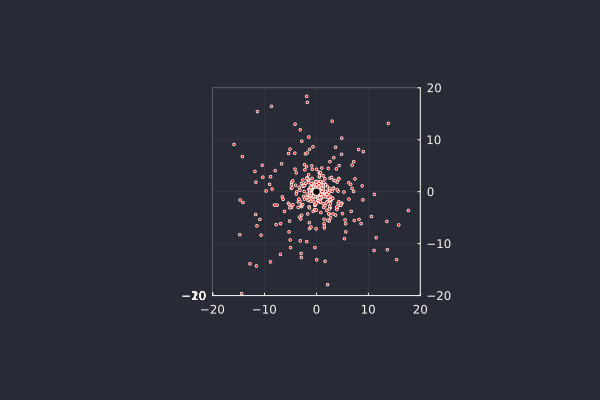

In [17]:

gif_galaxy(data,time,Target["NₛDisk"]+Target["NₛBulge"],[-20,20],[-20,20],[-20,20])
#gif_two_galaxies(data,time,Introoder["Nₛ"],Target["Nₛ"],[-20,30],[-30,30],[-30,20])


In [ ]:
Rminimum = Target["softening"] * Target["DiskRadius"]
Rdisk = (-log.(rand(Target["NₛDisk"]))*Target["DiskRadius"] .+Rminimum)*1u"1/kpc" #This (by inverse tansform sampling) gives us a negative exponential distribution on the masses. Basing myself on https://arxiv.org/pdf/1608.08350.pdf for this model
ϕdisk = 2π *rand(Target["NₛDisk"])
# Positions 
vecᵣ = ([Rdisk.*cos.(ϕdisk),Rdisk.*sin.(ϕdisk),zeros(Target["NₛDisk"])])
x = ustrip.(u"m",Target["center_pos"][1].+vecᵣ[1]*1u"kpc")#here, we strip our units into our 'integrating' unitlessness because units don't really play nice in arrays of arrays
y = ustrip.(u"m",Target["center_pos"][2].+vecᵣ[2]*1u"kpc")
z = ustrip.(u"m",Target["center_pos"][3].+vecᵣ[3]*1u"kpc")

# Velocities
BlackMagic = 
vecᵥ = []
for j ∈ 1:Target["NₛDisk"]
    push!(vecᵥ,ustrip.(u"m/s",√(G *Target["mass"]/(Rdisk[j]*1u"kpc"))) * normalize(reduce(vcat,transpose(vecᵣ))[:,j] × Target["normal"]))
end
vecᵥ

500-element Vector{Any}:
 [-330322.6745825863, 281095.2459081606, 0.0]
 [-20093.30461716667, 154582.0548522797, 0.0]
 [-159874.7528993476, 130040.73443415255, 0.0]
 [-215515.36645204318, -412625.0670183843, 0.0]
 [1960.3399864288253, -107176.65487077825, 0.0]
 [-368208.27296864, -269216.9964111089, 0.0]
 [270083.8828769266, 19416.810500051197, -0.0]
 [154490.7252962348, -42154.70565496611, 0.0]
 [-270923.7048324102, 179953.26932036516, 0.0]
 [-182233.52051806834, -36783.669674797, 0.0]
 [591014.8030330193, -99332.91775833696, 0.0]
 [-60946.867845857494, 67142.22569306481, 0.0]
 [141622.77017269272, -209764.11232737394, 0.0]
 ⋮
 [-14933.109627849395, 915775.9637843149, 0.0]
 [-146630.3659642172, -22747.970426875865, 0.0]
 [269379.0654568179, 156567.02328019627, -0.0]
 [19672.65163465752, -97566.86232117037, 0.0]
 [-581198.6420276418, -164161.4940166007, 0.0]
 [511770.91569519986, 34554.320405508864, -0.0]
 [221811.6555024291, -336610.6000768314, 0.0]
 [-88314.60198199566, -198345.116142

In [ ]:
dT=ustrip(u"s",0.05u"Myr")
rₘ=ustrip(u"m",Target["softening"]*Target["BulgeRadius"])
Nₛ=Target["NₛDisk"]+Target["NₛBulge"]

#Galaxy stuff
M = Target["mass"]
X,Y,Z = ustrip.(u"m",Target["center_pos"])
Vx,Vy,Vz = ustrip.(u"m/s",Target["center_vel"])

#star stuff
x=reduce(vcat,transpose(Target["star_pos"]))[:,1]
y=reduce(vcat,transpose(Target["star_pos"]))[:,2]
z=reduce(vcat,transpose(Target["star_pos"]))[:,3]
vx=reduce(vcat,transpose(Target["star_vel"]))[:,1]
vy=reduce(vcat,transpose(Target["star_vel"]))[:,2]
vz=reduce(vcat,transpose(Target["star_vel"]))[:,3]
T=0

r = max.(sqrt.((x.-X).^2 + (y.-Y).^2 + (z.-Z).^2),rₘ)
vx += -ustrip(u"m^3*s^-2",G*M)*((x.-X)./r.^3) *dT
vy += -ustrip(u"m^3*s^-2",G*M)*((y.-Y)./r.^3) *dT
vz += -ustrip(u"m^3*s^-2",G*M)*((z.-Y)./r.^3) *dT
x += vx*dT
y += vy*dT
z += vz*dT
Vx += 0
Vy += 0
Vz += 0
X += Vx*dT
Y += Vy*dT
Z += Vz*dT
T += dT *ustrip(u"Myr",1u"s")


0.05

6-element Vector{Int64}:
 1
 2
 3
 1
 2
 3